---

 # <center><span style="color:red">**Práctica 1: Lectura y exploración inicial de datos.**</span></center>

---

In [55]:
# Librerías necesarias para realizar la práctica
# -----------------------------------------------------
# Manipulación y lectura de datos
import netCDF4 as nc
import pandas as pd
import numpy as np
from datetime import timedelta,datetime

# Estadistica
from scipy import stats

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import math
import warnings
warnings.filterwarnings('ignore')

<p style="text-align: justify;"></p>

## <span style="color:green">Apartado 1</span>:   
<span style='color:black'>Análisis de la temperatura media diaria de la superficie en Barajas. En este apartado se pretende analizar el ciclo estacional y más en particular dos meses: enero y julio, con tres bases de datos diferentes para poder intercomparar los resultados. También se prentende comparar si ha habido un cambio en la temperatura a lo largo del periodo disponible y si las bases de datos son comparables.</span>

### <span style='color:darkgreen'>1.1. Datos de estación</span>

<span style='color:black'>A la estación de Barajas le corresponde el código 08221099999. Descargaremos los datos que corresponden a esa estación.</span>

In [38]:
# Necesito sabes la latitud y longitud de la estación de Barajas
estacion = 'BARAJAS'

# Voy a intentar conseguir el código de la estación para ello necesito leer 
# el siguiente archivo
informacion = 'data/isd-history.csv'

df_codigos = pd.read_csv(informacion)
barajas = df_codigos[df_codigos['STATION NAME']==estacion]

# Voy a conseguir el código de barajas a ver si es el mismo que el 
# proporcionado por Belén
codigo = str(barajas['USAF'].values[0]) + '-' + str(barajas['WBAN'].values[0])

print(f'Seleccionada la estacion {estacion.capitalize()} con código {codigo}')

Seleccionada la estacion Barajas con código 082210-99999


<span style='color:black'>El código proporcionado por Belén y obtenido de los datos es el mismo, asi que procedo a descargarme los datos con el código proporcionado por Belen en las anteriores clases de la asignatura.</span>

In [39]:
# Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
colNames = ['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
dataType = ['int','int','int','int',np.float64,'float','float','float','float','float','float','float',]

# Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
# (Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)

# D: de la página sacamos las posiciones en el str en la que está cada tipo de datos (cada columna) y la pasamos:
limits = [(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)] 
yearInit = 1973
yearEnd  = 2020

# lectura de los datos:
concat_list = []
for iyr in range(yearInit, yearEnd, 1):
    # Descomentar la siguiente línea si se prefiere hacer lectura directamente desde el servidor (lento)
    fil = 'https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+codigo +'-'+ str(iyr)+'.gz'
    # si tuvieras los datos en una carpeta, pondrias el path y el nombre de la estación
    # fil=path + station+'-'+str(iyr)+'.gz'
    data = pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames, colspecs=limits)
    
    # data_array = np.concatenate((data_array,data.values),axis=0)
    # df = df.append(data) # Esto ya no se usa, no le gusta a Python, dice que lo cambie por concat
    concat_list.append(data)
    
df = pd.concat(concat_list)

dictTpe = dict(zip(colNames,dataType))

isd_data = df.replace(-9999, np.NaN)
isd_data = isd_data.astype(dictTpe, copy=True)

# Datos cada: 6h 

In [40]:
# Voy a poner de índice la fecha en datetime
def get_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    
    """_summary_

    Args:
        df (pd.DataFrame): _description_

    Returns:
        pd.DataFrame: _description_
    """
    
    cols=['year', 'month', 'day']
    df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), 
                                axis="columns")
    	
    df['date']=pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df[['temp']]

In [41]:
df_reformed = get_datetime_index(isd_data)

#### <span style='color:darkblue'>1.1.1. Caracterización del ciclo estacional</span>

In [42]:
# This are the columns I want to play with
columns = ['year', 'month', 'day', 'hour', 'temp']
isd_data = isd_data[columns]

# Están multiplicados por 10 los datos de temperatura
# isd_data['temp'] /= 10 

In [43]:
# Nombre de los meses
months= ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
         'September', 'October', 'November', 'December']

# Números de meses
number_months = list(range(1,13))

# Diccionario con contiene si número de mes y su nombre
months_dic = dict(zip(number_months, months))

In [44]:
# Los datos están multiplicados por 10 
isd_data['temp'] = isd_data['temp']/10

Text(0.5, 1.0, 'Ciclo Estacional')

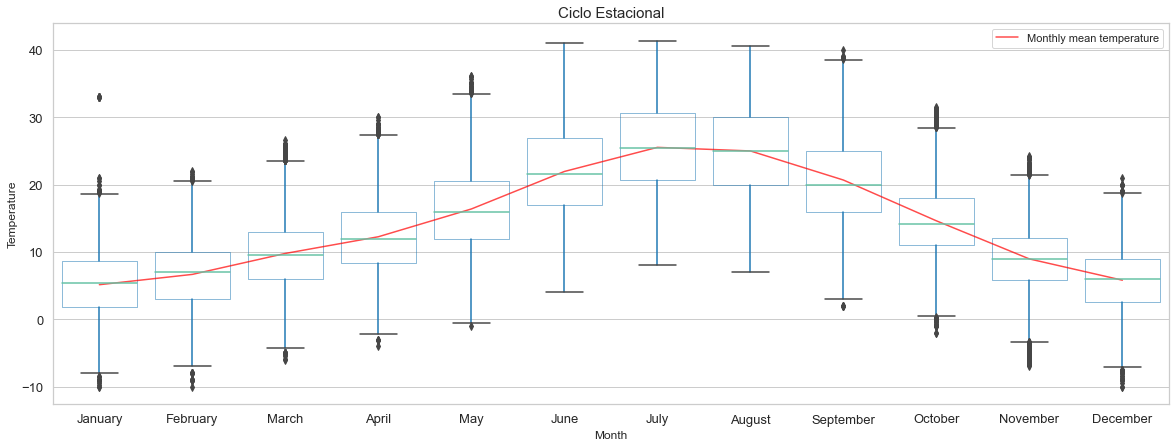

In [45]:
plt.figure(figsize=(20,7))
sns.boxplot(data = isd_data, x='month', y='temp', boxprops={"facecolor": "None", "edgecolor": sns.color_palette("Paired")[1],
                          "linewidth": 0.5},
            medianprops ={'color':sns.color_palette("Set2")[0]},
            whiskerprops={'color':sns.color_palette("Paired")[1]})

plt.plot(np.arange(0,12), isd_data.groupby(['month'], dropna=True).mean()['temp'], color='red', alpha=0.7, label='Monthly mean temperature')

plt.legend(loc='best')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.xticks(np.arange(12),months_dic.values(), size=13)
plt.yticks(np.arange(-10,50,10), size=13)
plt.title('Ciclo Estacional',fontsize=15)

#### <span style='color:darkblue'>1.1.2 Caracterización de la distribución para enero y julio</span>

<div span style='color:black'>
<li> Dibuja el histograma con todos los datos para cada mes.</li>
<li> Haz un ajuste a la distribución normal (recuerda lo visto en el tema 2 de estimación puntual de
parámetros).</li>
<li> Calcula los percentiles 5% y 95% para enero y julio separadamente tanto de la distribución
empírica (en Python puedes emplear la función quantile del paquete de numpy), como empleando el
ajuste (en Python, en el módulo stats tienes stats.norm.ppf() que te puede ayudar).</li>
<li>  Calcula el intervalo de confianza para la media con un nivel de confianza del 95% para enero y
julio separadamente. (En Python, recuerda que tienes stats.norm.ppf() para ayudarte).</li>
<li>  Comenta todos los resultados.</li>
</div>


Stadistic data from January
Percentiles for the data in January are: q(5%)=-2.80 and q(95%)= 12.30
Percentiles for the theoric distribution in January are: q(5%)=-2.54 and q(95%)= 12.82
IC= [5.14+-0.05] (ºC)
With scipy function:(5.090559651080425, 5.193808356080203)
------------------------------------------------------------------------------
Stadistic data from June
Percentiles for the data in June are: q(5%)=12.00 and q(95%)= 33.00
Percentiles for the theoric distribution in June are: q(5%)=11.44 and q(95%)= 32.50
IC= [21.97+-0.07] (ºC)
With scipy function:(21.894853495731844, 22.038984570853344)
------------------------------------------------------------------------------


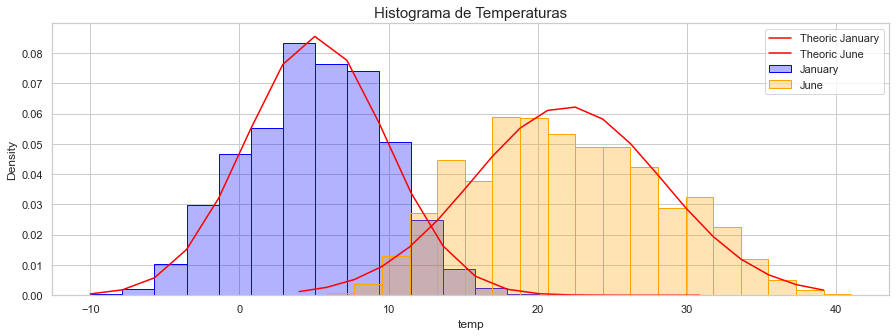

In [93]:
plt.figure(figsize=(15,5))

meses = [1,6]
colores = ['blue', 'orange']
for i in meses:
    # Creo una variable con los datos que quiero representar
    data = isd_data[isd_data['month']==i]['temp']

    # Plot de histograma
    sns.histplot(data=data,color=colores[meses.index(i)], stat='density',
                bins=20, alpha=0.3, edgecolor=colores[meses.index(i)], label=months_dic[i])

    # Distribución normal sobre el histograma
    mean = data.mean()
    std  = data.std()
    n= np.shape(data)[0]
    bins= np.arange(np.min(data),np.max(data),step=(np.max(data)-np.min(data))/20) 
    normal_distribution= stats.norm.pdf(bins,mean,std)
    
    plt.plot(bins,normal_distribution,'red',label=f'Theoric {months_dic[i]}')

    # Calculo de quantiles
    quantile_theoric = [stats.norm.ppf(0.05,mean,std),stats.norm.ppf(0.95,mean,std)]
    
    # Print de los datos que tengo en los percentiles
    print(f'Stadistic data from {months_dic[i]}')
    print(f'Percentiles for the data in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(data.quantile(q=0.05), data.quantile(q=0.95)))
    print(f'Percentiles for the theoric distribution in {months_dic[i]} are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))

    
    # Intervalo de confianza del 95%
    alfa=0.05
    
    # We must use the t-student distribution, beacuse with don't now the standard deviation of the data
    t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
    ic= t_alpha_2*std/np.sqrt(n)
    print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))

    ic_scipy=stats.t.interval(alpha=0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
    print(f'With scipy function:{ic_scipy}')
    
    print('------------------------------------------------------------------------------')
    
# Cosas globales que quiero representar en el gráfico
plt.title('Histograma de Temperaturas',fontsize=15)
plt.legend()

#### <span style='color:darkblue'>1.1.3 Cambio climático</span>

<span style='color:black'>Calcula la media de la temperatura en enero y julio para el periodo 1973-
1989. Calcula la desviación típica de la temperatura en enero y julio para el periodo 1973-1989 y el
periodo 1990-2019. Haz los contrastes de hipótesis pertinentes para decir si ha cambiado
significativamente la temperatura en Barcelona en ambos periodos.</span>

### <span style='color:darkgreen'>1.2.  Análisis con datos de la base CPC de temperatura global diaria.</span>

#### <span style='color:darkblue'>1.2.1 Caracterización del ciclo estacional</span>

In [48]:
def get_index(df:pd.DataFrame, lat:np.array, lon:np.array)->tuple:
    """_summary_

    Args:
        df (pd.DataFrame): DataFrame donde tengo la información de la estación
        lat (np.array): todos los datos de latitud que tengo dentro del netCDf
        lon (np.array): todos los datos de longitud que tengo dentro del netCDf

    Returns:
        tuple: _description_
    """
    
    lat_barajas = float(barajas['LAT'])
    lon_barajas = float(barajas['LON'])

    lat_dif = (lat-lat_barajas)**2
    lon_dif = (lon-lon_barajas)**2

    # Los convierto en lista ya que así encuentro fácilmente su index
    lat_dif = lat_dif.tolist()
    lon_dif = lon_dif.tolist()

    # Consigo los ídices estos siendo el valor mínimo de la diferencia cuadrada
    index_lat = lat_dif.index(min(lat_dif))
    index_lon = lon_dif.index(min(lon_dif))
    
    return index_lat, index_lon

In [49]:
def convert_data(data:any)->list:
    """Función para convertir los datos de fecha de formato timedelta de horas a un string con fechas legibles.

    Args:
        data (any): objeto nc.Dataset donde tenemos los datos mensuales de temperatura para todas las latitudes y longitudes

    Returns:
        list: las fechas en formato str de los datos de tiempo dentro de ese nc.Dataset
    """
    time = data.variables['time'][:]

    # El formato en el que tenemos dado el tiempo no nos sirve asique vamos a cambiarlo
    # data.variables['time'].units -> 'hours since 1900-01-01 00:00:00'
    dates = []
    
    for data_indays in time:
        specific_data = datetime(1900,1,1,0,0,0)
        new_date = str(specific_data + timedelta(hours=int(data_indays)))
        dates.append(new_date)
        
    return dates

In [50]:
# Voy a hacerlo con los datos de CPC_global_daily
folder = 'CPC_global_daily'

# Creo un pandas dataframe vacio
df_list=[]
for mes in range(1,13):
    data = nc.Dataset(f'data/{folder}/tmean_PI_mes_{mes}.nc')
    
    lon = data.variables['lon'][:]
    lat = data.variables['lat'][:]
    
    # Ahora ya obtendo los datos y los almaceno en un pandas DataFrame
    # [time, lat,lon]
    index_lat,index_lon = get_index(barajas, lat, lon)
    tmean = data.variables['tmean'][:,index_lat,index_lon]
    
    dates = convert_data(data)
    df = pd.DataFrame(data={f'{mes}':tmean}, index = dates)
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    df_list.append(df)

Text(0.5, 1.0, 'Ciclo Estacional')

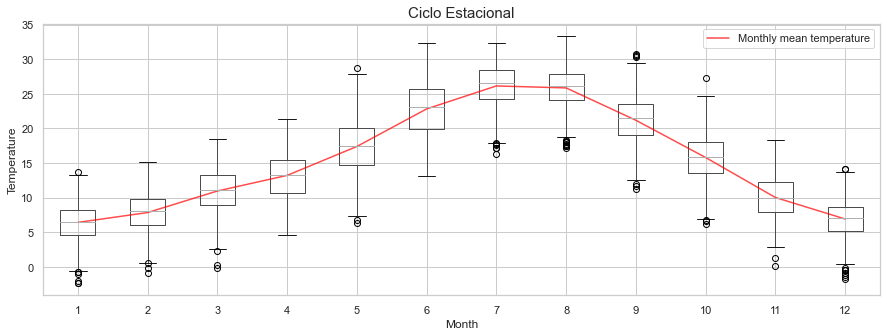

In [51]:
df_1=pd.concat(df_list, axis=1)

df_1.boxplot(figsize=(15,5))
plt.plot(list(range(1,13)), df_1.mean(), color='red',alpha=0.7,label = 'Monthly mean temperature')

plt.legend(loc='best')
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.title('Ciclo Estacional',fontsize=15)

<AxesSubplot:>

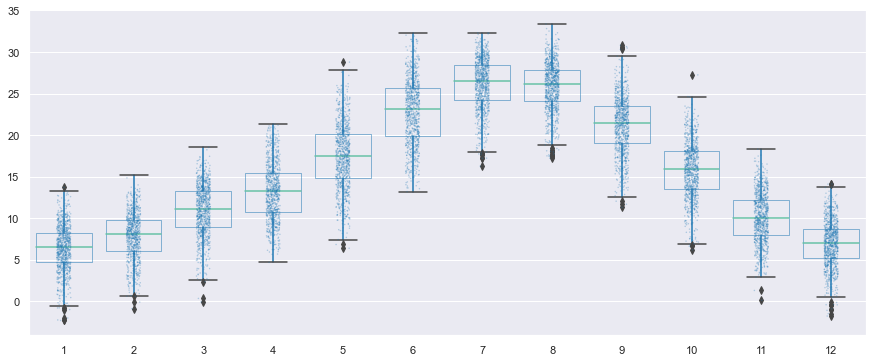

In [52]:
sns.set_theme(rc={'figure.figsize':(15,6)})
sns.boxplot(data=df_1, boxprops={"facecolor": "None", "edgecolor": sns.color_palette("Paired")[1],
                          "linewidth": 0.5},
            medianprops={'color':sns.color_palette("Set2")[0]},
            whiskerprops={'color':sns.color_palette("Paired")[1]})

sns.stripplot(data=df_1, color=sns.color_palette("Paired")[1],alpha=0.3, size=1.5)

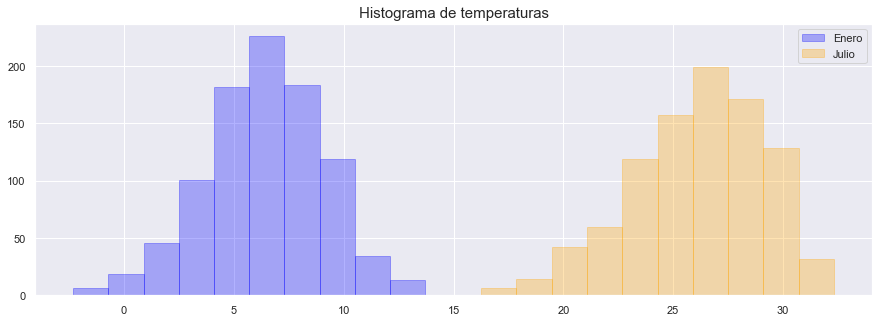

In [53]:
df_list[0].hist(figsize=(15,5), color='blue', alpha=0.3, edgecolor='blue',label='Enero')
plt.title('Histograma de temperaturas',fontsize=15)
plt.hist(df_list[6],color='orange', alpha=0.3, edgecolor='orange', label='Julio')
plt.legend()

In [54]:
# Voy a hacerlo con los datos de GPCP
folder = 'HadISST1'


data = nc.Dataset(f'data/{folder}/HadISST1_sst_1870-2019.nc')
    
lon = data.variables['longitude'][:] # data.variables.keys[0]
lat = data.variables['latitude'][:]  # data.variables.keys[1]

# Mirar los bounds: optional
# print(data.variables['lat_bnds'][:],data.variables['lon_bnds'][:])

# Datos de precipitación
precip = data.variables['sst'][:] # data.variables.keys[-1]

# Datos de tiempo: units: days since 1800-01-01 00:00:00
fecha = data.variables['time'][:]

# Convert ddata
dates = []

for data_indays in fecha:
    specific_data = datetime(1800,1,1,0,0,0)
    new_date = str(specific_data + timedelta(days=int(data_indays)))
    dates.append(new_date)
    
# data.variables['precip'].shape = (time = 12 datos, lat = 72 datos, lon = 144 datos)


### <span style='color:darkgreen'>1.3.  Análisis con datos de la base NCEP/NCAR</span>

## <span style="color:green">Apartado 2</span>:   

### <span style='color:darkgreen'>2.1 Caracterización de la climatología invierno / verano</span>

### <span style='color:darkgreen'>2.2 Calcula la media y la desviación típica en el periodo 1870-1930, 1931-1975 y 1975-2019 y representa</span>

### <span style='color:darkgreen'>2.3 Evaluación de las series temporales de anomalías en distintas regiones para el periodo completo</span>